# **Setting Up Environment**

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.models import load_model
!pip install python-whois
!pip install pyquery
from UrlFeaturizer import UrlFeaturizer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Load the Feature Extracted Dataset

In [4]:
data = pd.read_csv('/content/drive/MyDrive/CN/feature.csv')

# **Preprocessing**

In [5]:
class_mapping = {
    "Benign_list_big_final": "Benign",
    "Malware_dataset": "Malware",
    "phishing_dataset": "Phishing",
    "spam_dataset": "Spam"
}
data['File'] = data['File'].map(class_mapping)
data.drop(columns=['Unnamed: 0'], inplace=True)
data.replace(True,1,inplace = True)
data.replace(False,0,inplace = True)

Standardization

In [6]:
# Standardize the features
scaler = StandardScaler()
data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])

# Save the scaler object
pickle.dump(scaler, open('scaler.sav', 'wb'))

<ipython-input-6-be112450a885>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])


Encoding Target Variable

In [7]:
# Encoding the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(data["File"])
# Save the encoder object
np.save('lblenc.npy', encoder.classes_)

#Dropping the target column
X = data.drop(columns=["File"])

Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Reshape Inputs for CNN

In [9]:
# Reshape inputs for CNN
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# **Model Architecture**

In [10]:
# Model Architecture
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))  # Adjusted dropout rate
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))  # Adjusted dropout rate
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))  # Adjusted dropout rate
model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dense(np.unique(y).shape[0], activation='softmax'))  # Adjusted number of units

# Compile the model with an Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model Training

In [11]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
reduce_lr = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch % 10 == 0 else lr)


# Fit the model to the training data
history = model.fit(X_train_cnn, y_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr])
model.save('best_model.h5')

Epoch 1/50
1091/1091 [==============================] - 52s 42ms/step - loss: 0.8917 - accuracy: 0.6460 - val_loss: 0.6271 - val_accuracy: 0.7535 - lr: 9.0000e-04
Epoch 2/50
   3/1091 [..............................] - ETA: 28s - loss: 0.7590 - accuracy: 0.6979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1091/1091 [==============================] - 32s 29ms/step - loss: 0.6548 - accuracy: 0.7451 - val_loss: 0.5535 - val_accuracy: 0.7895 - lr: 9.0000e-04
Epoch 3/50
1091/1091 [==============================] - 29s 27ms/step - loss: 0.5914 - accuracy: 0.7716 - val_loss: 0.5146 - val_accuracy: 0.8063 - lr: 9.0000e-04
Epoch 4/50
1091/1091 [==============================] - 29s 27ms/step - loss: 0.5598 - accuracy: 0.7820 - val_loss: 0.4946 - val_accuracy: 0.8111 - lr: 9.0000e-04
Epoch 5/50
1091/1091 [==============================] - 29s 27ms/step - loss: 0.5332 - accuracy: 0.7966 - val_loss: 0.4860 - val_accuracy: 0.8173 - lr: 9.0000e-04
Epoch 6/50
1091/1091 [==============================] - 28s 26ms/step - loss: 0.5123 - accuracy: 0.8041 - val_loss: 0.4703 - val_accuracy: 0.8212 - lr: 9.0000e-04
Epoch 7/50
1091/1091 [==============================] - 29s 27ms/step - loss: 0.4994 - accuracy: 0.8076 - val_loss: 0.4636 - val_accuracy: 0.8209 - lr: 9.0000e-04
Epoch 8/50
1091/1091 [===========

Training History

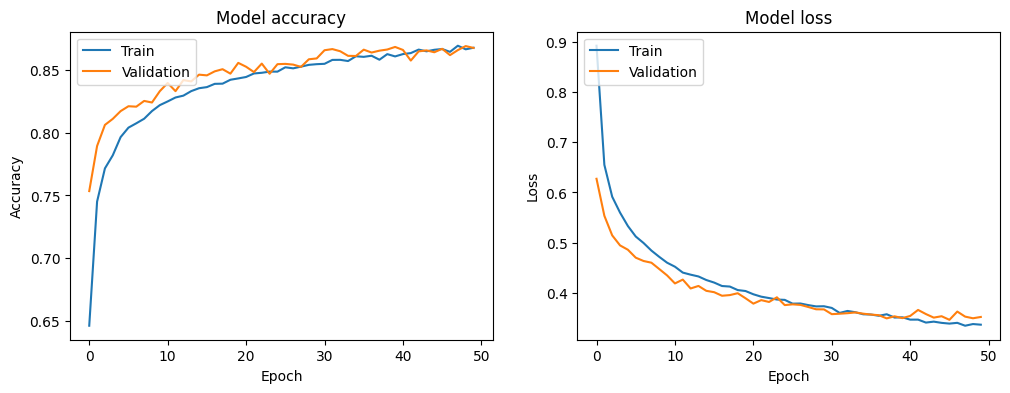

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# **Model Evaluation**

In [13]:
# Perform predictions on the testing set
y_pred = model.predict(X_test_cnn)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
class_names = ["Benign", "Malware", "Phishing", "Spam", "Defacement"]

classification_rep = classification_report(y_test, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(classification_rep)


341/341 [==============================] - 3s 6ms/step
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.96      0.96      2167
     Malware       0.88      0.93      0.91      2273
    Phishing       0.79      0.80      0.79      2013
        Spam       0.91      0.92      0.91      2456
  Defacement       0.84      0.75      0.79      1998

    accuracy                           0.88     10907
   macro avg       0.87      0.87      0.87     10907
weighted avg       0.88      0.88      0.88     10907



Making Predictions


In [14]:
# Load the LabelEncoder and StandardScaler
encoder = LabelEncoder()
encoder.classes_ = np.load('lblenc.npy', allow_pickle=True)
scaler = pickle.load(open('scaler.sav', 'rb'))

# Load the model
model = load_model("best_model.h5")

# The URL to predict
url = 'http://astore.amazon.co.uk/allezvinsfrenchr/detail/1904010202/026-8324244-9330038'

# Featurize the URL
url_featurizer = UrlFeaturizer(url)
features = url_featurizer.run()

# The order of the features
order = ['bodyLength', 'bscr', 'dse', 'dsr', 'entropy', 'hasHttp', 'hasHttps',
       'has_ip', 'numDigits', 'numImages', 'numLinks', 'numParams',
       'numTitles', 'num_%20', 'num_@', 'sbr', 'scriptLength', 'specialChars',
       'sscr', 'urlIsLive', 'urlLength']

# Prepare the features for prediction
test = [features[i] for i in order]
test = pd.DataFrame(test).replace(True,1).replace(False,0).to_numpy().reshape(1,-1)

# Standardize the features
test = scaler.transform(test)

# Reshape the input data to fit the model input shape
test = test.reshape(test.shape[0], test.shape[1], 1)

# Make the prediction
predicted = np.argmax(model.predict(test), axis=1)

# Convert the numerical prediction to class label
print(encoder.inverse_transform(predicted)[0])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 624ms/step
Spam
